In [1]:
import numpy as np
import rdkit
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, RDConfig, Geometry, RDLogger
from rdkit.Chem import AllChem, ChemicalFeatures, rdDistGeom, rdMolTransforms, rdShapeAlign, Draw, rdChemicalFeatures
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment
from rdkit.Chem.Draw import IPythonConsole, MolDrawing
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
from rdkit.Chem.FeatMaps import FeatMapUtils, FeatMaps
import os
import itertools
import copy
import random
import scipy
import py3Dmol
import pickle
DrawingOptions.includeAtomNumbers=True

How to implement ligand library-based ph4 model generation:

- read in ligands
- generate conformer ensemble for each ligand
    - optimize energies?
    - filter out high-energy conformers
    - align conformer ensemble
- the LigandScout method:
    - take two (least flexible) molecules, align all conformers
    - get ph4 features for each conformer
    - detect and interpolate common features
    - align intermediate model to next least flexible molecule
    - repeat until all ligands have been processed, output final model
    - potential problem: until the rdkit alignment bug w/ multiple matching is fixed, this might not work
- alternatively:
    - align every single conformer of every molecule all at once
    - get all ph4 features
    - interpolate/group all features at once (e.g. via clustering, see https://projects.volkamerlab.org/teachopencadd/talktorials/T009_compound_ensemble_pharmacophores.html#Extract-pharmacophore-features)
        - this repo: https://github.com/AngelRuizMoreno/ConcensusPharmacophore/tree/main has a method that should hopefully work well
    - do some filtering to remove insufficiently represented features

In [85]:
EGFR_ligands = pd.read_csv("EGFR_actives_nM_combined.ism",header=None,usecols=[0,1,4],
                           names=['Smiles','ID','Potency [nM]'],sep=' ')
EGFR_ligands

,Smiles,ID,Potency [nM]
0,c1ccc2cc3c(cc2c1)c(ncn3)Nc4cccc(c4)Br,101343,0.003
1,CCOc1cc2c(cc1OCC)ncnc2Nc3cccc(c3)Br,55676,0.006
2,CN(C)c1cc2c(cn1)ncnc2Nc3cccc(c3)Br,81022,0.006
3,COc1cc2c(cc1OC)ncnc2Nc3cccc(c3)Br,39672,0.006
4,CNc1cc2c(cn1)ncnc2Nc3cccc(c3)Br,80973,0.008
...,...,...,...
1615,CCOc1cc2c(cc1OCC)ncc(c2Nc3ccc(c(c3)Cl)F)C#N,181930,980.000
1616,c1ccc(cc1)NC(=S)N(Cc2ccc(cc2)F)Cc3cccc(c3O)Br,598178,980.000
1617,c1ccc(cc1)CCCCCn2c3ccc(cc3c4c2CCC(C4)N)OCCc5cc...,628391,980.000
1618,CN1CCN(CC1)CCCNc2ncc3cc(c(nc3n2)NC(=O)NCc4cccc...,75477,980.000


In [ ]:
EGFR_mols = [LE_conf_from_smiles(x,random_seed=20251002) for x in EGFR_ligands['Smiles']]
with open("EGFR_LE_ligands.pkl","wb") as file:
    pickle.dump(LE_hit_mols,file)

In [ ]:
test_ligands = pd.read_csv("hERG_ligands.tsv",sep='\t')
test_ligands.columns

In [ ]:
test_ligands.head()

In [52]:
ligands = pd.read_csv("hERG_ligands.tsv",sep="\t",usecols=['Molecule ChEMBL ID',
                                                          'Smiles','Standard Relation',
                                                          'Standard Value','Standard Units',
                                                          'pChEMBL Value'])
ligands.head(10)

,Molecule ChEMBL ID,Smiles,Standard Relation,Standard Value,Standard Units,pChEMBL Value
0,CHEMBL48029,c1ccc(COc2ccc(CCNc3ccncc3)cc2)cc1,'=',130.0,nM,6.89
1,CHEMBL2158563,CCN(CC)CCOc1cc(-c2nc(SCC(=O)NC)nc3[nH]cc(C#N)c...,'=',3140.0,nM,5.50
2,CHEMBL4102140,N#C[C@H]1CCOC[C@@H]1n1cc(C(N)=O)c(Nc2ccc(OC(F)...,'=',25000.0,nM,4.60
3,CHEMBL4096821,N#C[C@H]1CCOC[C@@H]1n1cc(C(N)=O)c(Nc2ccc(-n3cc...,'=',13200.0,nM,4.88
4,CHEMBL1771096,Cc1cnc(N2CCC(C3CCN(c4cc(C)nc(C#N)n4)CC3)CC2)cn1,'=',10600.0,nM,4.97
5,CHEMBL487273,NC(=O)Nc1sc(-c2ccccc2)cc1C(=O)N[C@H]1CCCNC1,'>',31600.0,nM,NaN
6,CHEMBL5992117,CN(C)C[C@H](c1ccc2ccccc2c1)[C@H](OCCO)c1ccccc1,'=',6600.0,nM,5.18
7,CHEMBL5998115,CNCC(CCc1ccccc1)[C@H](O)c1ccccc1,'=',15000.0,nM,4.82
8,CHEMBL27759,Nc1ccccc1NC(=O)c1ccc(CNC(=O)OCc2cccnc2)cc1,'>',30000.0,nM,NaN
9,CHEMBL1808624,O=C(/C=C/c1ccc2c(c1)CN(C(=O)Cc1ccccc1)C2)NO,'>',30000.0,nM,NaN


In [ ]:
len(ligands.loc[ligands['pChEMBL Value']>=8])

In [ ]:
def confs_from_smiles(smiles,num_embed=100,align=True,random_seed=-1):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    confs = AllChem.EmbedMultipleConfs(mol,numConfs=num_embed,randomSeed=random_seed)
    optimize_res = AllChem.MMFFOptimizeMoleculeConfs(mol)
    AllChem.AlignMolConformers(mol)
    return mol

In [50]:
def LE_conf_from_smiles(smiles,num_embed=100,random_seed=-1):
    mol=Chem.MolFromSmiles(smiles)
    mol=Chem.AddHs(mol)
    confs = AllChem.EmbedMultipleConfs(mol,numConfs=num_embed,randomSeed=random_seed)
    res = AllChem.MMFFOptimizeMoleculeConfs(mol)
    LE_conf_ID = res.index(min(res,key=lambda t: t[1]))
    out_mol = Chem.Mol(mol,confId=LE_conf_ID)
    return out_mol

In [53]:
ligand_subset = ligands.sample(frac=0.1,random_state=20250930)
hits = ligand_subset.loc[ligand_subset['Standard Value']<=5]

In [67]:
hits

,Molecule ChEMBL ID,Smiles,Standard Relation,Standard Value,Standard Units,pChEMBL Value
3297,CHEMBL3422965,COc1nc2c(CCC34CCC(NCc5ccc6c(n5)NC(=O)CO6)(CC3)...,'=',2.490,nM,8.60
4617,CHEMBL1258724,Cc1ccccc1C(C)N1[C@@H]2CC[C@H]1C[C@H](Oc1cccc(C...,'=',4.900,nM,8.31
11635,CHEMBL5792092,Nc1nccn1Cc1cn(-c2cc(F)cc(C(F)F)c2)nn1,'=',2.130,nM,8.67
15536,CHEMBL5794967,CC(F)(F)c1cc(-n2cc(Cn3ccnc3N)nn2)ccc1Cl,'=',0.510,nM,9.29
14688,CHEMBL5947456,C[C@@H]1Cc2c(ccc3[nH]ncc23)[C@@H](c2ccc(NC3CN(...,'=',1.200,nM,8.92
4335,CHEMBL3422983,COc1ccc2ncc(C#N)c(CC(O)C34CCC(NCc5ccc6c(n5)NC(...,'=',2.580,nM,8.59
15144,CHEMBL4540910,COCCC#Cc1c(Cl)c2c(Cl)cc(C(N)=O)nc2n1[C@H]1CCCNC1,'=',3.000,nM,8.52
18558,CHEMBL5839811,C[C@@H]1Cc2c(ccc3[nH]nc(F)c23)[C@@H](c2ccc(OC3...,'=',0.880,nM,9.06
14001,CHEMBL5770484,CC(C)c1nccn1Cc1cn(-c2ccc(Cl)c(OC(F)F)c2)nn1,'=',3.120,nM,8.51
5802,CHEMBL460009,CC(C[C@H](NC(=O)C1CCC1)c1ccccc1)N1CCC(n2cc(-c3...,'=',4.700,nM,8.33


In [55]:
LE_hit_mols = [LE_conf_from_smiles(smi,random_seed=20251002) for smi in hits['Smiles']]
with open("hERG_LE_test_hits.pkl","wb") as file:
    pickle.dump(LE_hit_mols,file)

In [54]:
hit_mols = [confs_from_smiles(smi,random_seed=20250930) for smi in hits['Smiles']]
hit_mols

NameError: name 'confs_from_smiles' is not defined

In [ ]:
# save test hits for easier reuse later
with open("hERG_test_hits.pkl","wb") as file:
    pickle.dump(hit_mols,file)

In [2]:
with open("hERG_test_hits.pkl","rb") as file:
    hit_mols = pickle.load(file)

In [3]:
test_mol = hit_mols[0]
feature_path = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
feature_factory = ChemicalFeatures.BuildFeatureFactory(feature_path)
feats = feature_factory.GetFeaturesForMol(test_mol)
len(feats)

25

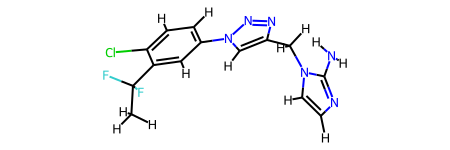

In [64]:
LE_hit_mols[3]

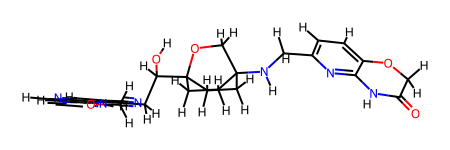

In [75]:
LE_hit_mols[5]

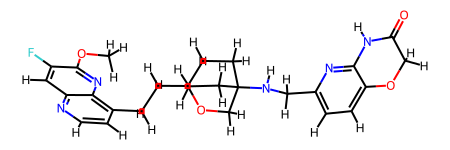

In [65]:
LE_hit_mols[0]

In [71]:
IPythonConsole.drawMol3D(LE_hit_mols[23]) # use this to align against

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

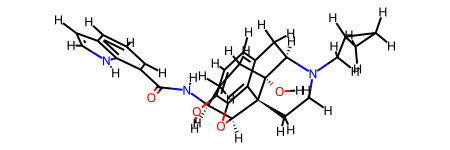

In [70]:
LE_hit_mols[24]

In [66]:
IPythonConsole.drawMol3D(LE_hit_mols[0])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [76]:
IPythonConsole.drawMol3D(LE_hit_mols[5])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
def prepare_conformers(queries,ref,embed_count=100):
    # ref should be molecule with one low-energy conformer
    

In [4]:
# probably don't want to actually use this, as the outputs are very poorly aligned to any individual conformer
# instead want to use lowest energy conformer to generate consensus
def ph4_features_from_conformers(mol,feature_factory=None):
    '''
    Extracts pharmacophore features and consensus positions from a conformer ensemble
    Args:
    mol: rdMol object (with conformers pre-generated and aligned) to get features from
    feature_factory: rdkit feature factory containing definitions of features of interest.
        if None, initializes default feature factory
    Returns:
    out_db: pd.DataFrame containing feature families and consensus centroid positions of each feature
    out_feats: list of rdFreeChemicalFeature objects corresponding to features
    '''
    # get default feature factory if required
    if feature_factory==None:
        feature_path = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
        feature_factory = ChemicalFeatures.BuildFeatureFactory(feature_path)
    # extract ph4 features
    feats = feature_factory.GetFeaturesForMol(mol)
    out_families = []
    out_positions = []
    out_feats = []
    # loop over features to get positions in each conformer
    for f in feats:
        positions=[]
        for i in [x.GetId() for x in mol.GetConformers()]:
            f.SetActiveConformer(i)
            positions.append(list(f.GetPos()))
        centroid = np.average(positions,axis=0)
        out_families.append(f.GetFamily())
        out_positions.append(list(centroid))
        of=rdChemicalFeatures.FreeChemicalFeature()
        of.SetFamily(f.GetFamily())
        of.SetPos(Geometry.rdGeometry.Point3D(centroid[0],centroid[1],centroid[2]))
        out_feats.append(of)
    out_positions = np.array(out_positions)
    out_db = pd.DataFrame({"Family":out_families,"x":out_positions[:,0],"y":out_positions[:,1],'z':out_positions[:,2]})
    return out_db,out_feats
        

In [5]:
test_db,test_feats = ph4_features_from_conformers(test_mol)
test_db.head(26)

,Family,x,y,z
0,Donor,-2.499235,0.047127,0.028937
1,Donor,-7.209333,0.669369,-0.278487
2,Acceptor,5.914815,2.692594,-0.305155
3,Acceptor,5.271699,0.640364,-0.014679
4,Acceptor,-5.315931,0.471457,-0.111703
5,Acceptor,-9.031182,0.853131,-0.443726
6,Acceptor,-8.376601,1.161486,-0.198345
7,Acceptor,0.832413,-0.701809,0.221091
8,Acceptor,6.475039,-1.951318,0.346321
9,Acceptor,7.671186,2.164918,-0.233754


In [46]:
from rdkit.Chem.Features.ShowFeats import _featColors as featColors
featColors['Donor']=(0,0,1)
featColors['Acceptor']=(1,0,0)
def colorToHex(rgb):
    rgb = [f'{int(255*x):x}' for x in rgb]
    return '0x'+''.join(rgb)
def drawit(m, feats, p=None, confId=-1, removeHs=True):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        if removeHs:
            m = Chem.RemoveHs(m)
        IPythonConsole.addMolToView(m,p,confId=confId)
        for feat in feats:
            pos = feat.GetPos()
            clr = featColors.get(feat.GetFamily(),(.5,.5,.5))
            print(clr)
            p.addSphere({'center':{'x':pos.x,'y':pos.y,'z':pos.z},'radius':.5,'color':colorToHex(clr)});
        p.zoomTo()
        return p.show()

In [49]:
drawit(test_mol,test_feats[0:14],confId=70)

(0, 0, 1)
(0, 0, 1)
(1, 0, 0)
(1, 0, 0)
(1, 0, 0)
(1, 0, 0)
(1, 0, 0)
(1, 0, 0)
(1, 0, 0)
(1, 0, 0)
(0, 0, 1)
(1, 0.8, 0.2)
(1, 0.8, 0.2)
(1, 0.8, 0.2)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [72]:
IPythonConsole.drawMols3D([test_mol]*100,confIds=range(100))

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [73]:
IPythonConsole.drawMols3D([test_mol,test_mol],confIds=[0,50])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
def consensus_ph4(ligands,feature_factory=None):
    if feature_factory == None:
        feature_path = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
        feature_factory = ChemicalFeatures.BuildFeatureFactory(feature_path)
    
                

In [ ]:
test_hit = [hit_mols[0]]
test_ph4 = consensus_ph4(test_hit)
test_ph4

In [ ]:
test_ph4.GetFeatures()